## Data Pre-Processing
I am following the methodology outlined in this [paper](https://www.researchgate.net/publication/388255558_Exploring_the_Effectiveness_of_Machine_Learning_and_Deep_Learning_Techniques_for_EEG_Signal_Classification_in_Neurological_Disorders) which I will be referencing a lot.

- Channel renaming (if necessary)
- Downsampling 
- Re-dimensioning (possibly for adding additional data if necessary)
- Channel removal

# Loading Data
- Below we can see a sample script for creating an instance of ```RawBrainVision```
- Important Note: do not rename ```.eeg```, ```.vhdr```, or ```.vmark``` files! 
- because you must pass the ```.vhdr``` header file as an arg to instantiate the ```RawBrainVision``` object, changing the file names can cause issues. 

In [1]:
import mne
import pandas as pd

#I only had space in my E: drive haha
#starting with subj-01
vhdr = r"E:\neuro_data\ds004796\sub-01\eeg\sub-01_task-rest_eeg.vhdr"

#instatiate
raw = mne.io.read_raw_brainvision(vhdr, preload=True)

#load tsv event data
tsv = r"E:\neuro_data\ds004796\sub-01\eeg\sub-01_task-rest_events.tsv"
events_df = pd.read_csv(tsv, sep='\t')

#show object info. Note lack of projections
print(raw.info)

print(events_df.head())

Extracting parameters from E:\neuro_data\ds004796\sub-01\eeg\sub-01_task-rest_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 661519  =      0.000 ...   661.519 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 127 EEG
 custom_ref_applied: False
 dig: 130 items (3 Cardinal, 127 EEG)
 highpass: 0.0 Hz
 lowpass: 280.0 Hz
 meas_date: 2021-05-13 15:14:47 UTC
 nchan: 127
 projs: []
 sfreq: 1000.0 Hz
>
     onset  duration event_type trial_type
0   23.318       NaN       S  1        NaN
1   23.324       NaN       S  2   stimulus
2  264.702       NaN       S 10        NaN
3  276.059       NaN       S  1        NaN
4  276.068       NaN       S  4   stimulus


we must also convert the annotations from the ```.tsv``` file and add them to ```raw```

In [2]:
#create annotations object
annotations = mne.Annotations(
    onset=events_df['onset'].values,
    duration=events_df['duration'].values,
    description=events_df['trial_type'].values
)

#set annotations
raw.set_annotations(annotations)

<RawBrainVision | sub-01_task-rest_eeg.eeg, 127 x 661520 (661.5 s), ~641.1 MiB, data loaded>

# Channel Renaming and setting Montage
- As you can see above, this data contains 127 channels.
- This is a high resolution but non-standard system that contains the standard 10-20 montage along with high density extensions
- the montage (naming structure) is stored in the  ```.vhdr``` file and the digitized montage (CapTrak 3D coordinates) is already read. 
- Preset montage ensures ```MNE``` knows the 3D positions of the electrodes, essential for spatial filtering, ICA, source localization etc.
- this article for more [info](https://www.nature.com/articles/s41597-024-03106-5)


[<DigPoint |        LPA : (-95.0, 0.0, 0.0) mm      : head frame>, <DigPoint |     Nasion : (0.0, 95.0, 0.0) mm       : head frame>, <DigPoint |        RPA : (95.0, 0.0, 0.0) mm       : head frame>, <DigPoint |     EEG #1 : (-29.4, 90.4, 0.0) mm     : head frame>, <DigPoint |     EEG #2 : (0.0, 67.2, 67.2) mm      : head frame>]


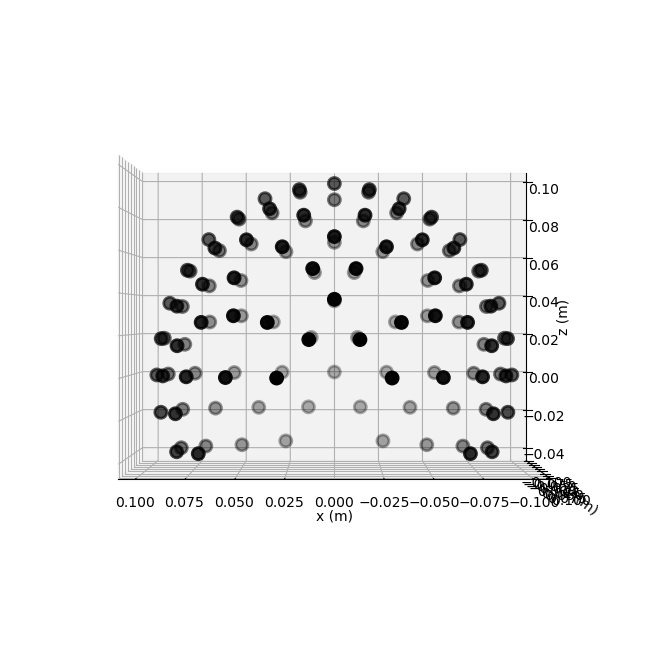

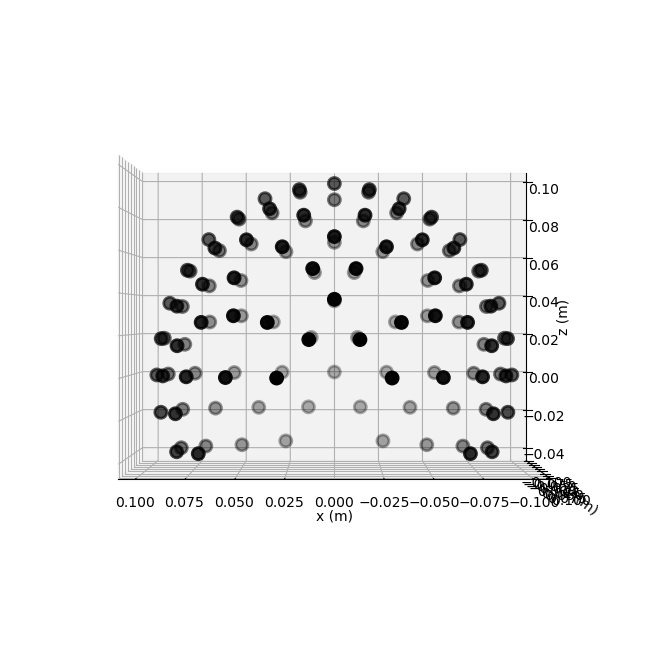

In [3]:
#strip trailing dots from channel names
raw.rename_channels(lambda name: name.strip('.'))

#check list of digitized points (DigPoint dictionary)
print(raw.info['dig'][:5])

#plot sensor layout in 3d space
raw.plot_sensors(kind='3d')

# Redimensioning
- This step is really only necessary if combining datasets with different numbers of channels (remember PEARL-NEURO is high definition at 128 channels which is non-standard)
- I will revisit this for implementation of the AHEPA EEG dataset


# Marking Bad Channels
- Sometimes individual channels malfunction and provide data that is too noisy to be usable. MNE-Python makes it easy to ignore those channels in the analysis stream without actually deleting the data in those channels.
- causes can involve migrating electrodes, electrode interferrence, muscle activity or even eye movements.
- Bad channels are stored in the ```Info['bads]``` object attached to the ```Raw``` or ```Epochs``` objects
- They can be marked manually or automatically

In [4]:
from mne.preprocessing import find_bad_channels_maxwell

#check premarked bad channels
print(raw.info['bads'])

#inspect manually
#raw_downsampled.plot()

#detect and interpolate automatically
try:
    raw.info['bads'],_ = find_bad_channels_maxwell(raw)
except ValueError as e:
    print(e)

[]
Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s


Scanning for bad channels in 132 intervals (5.0 s) ...
No channels match the selection.


# Artifact Removal
- We must remove artifacts and unwanted signal components, like physiological artifacts (sweat, blinks heartbeats) and non-physiological (electromagnetic interference)
- this will be done with Independent Component Analysis (ICA), a powerful technique that decomposes mixed signals into independent components 

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s


Fitting ICA to data using 127 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by explained variance: 84 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 602.7s.


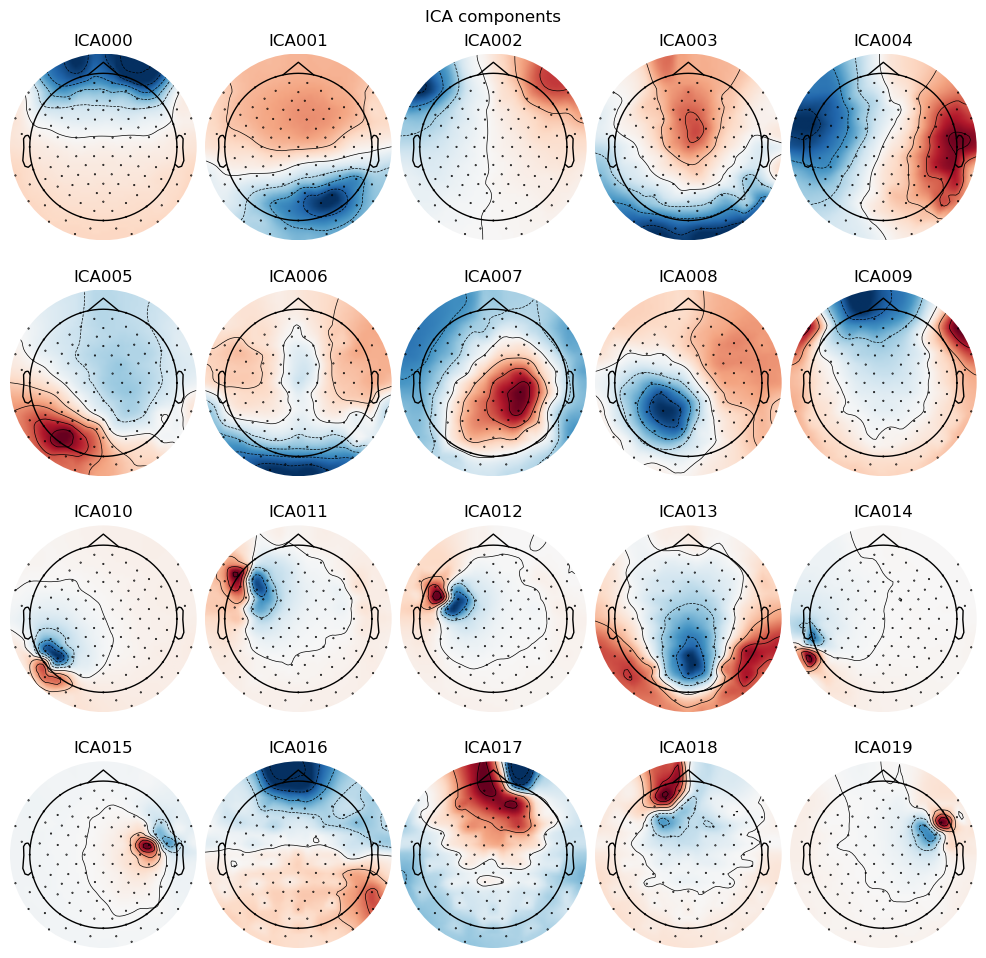

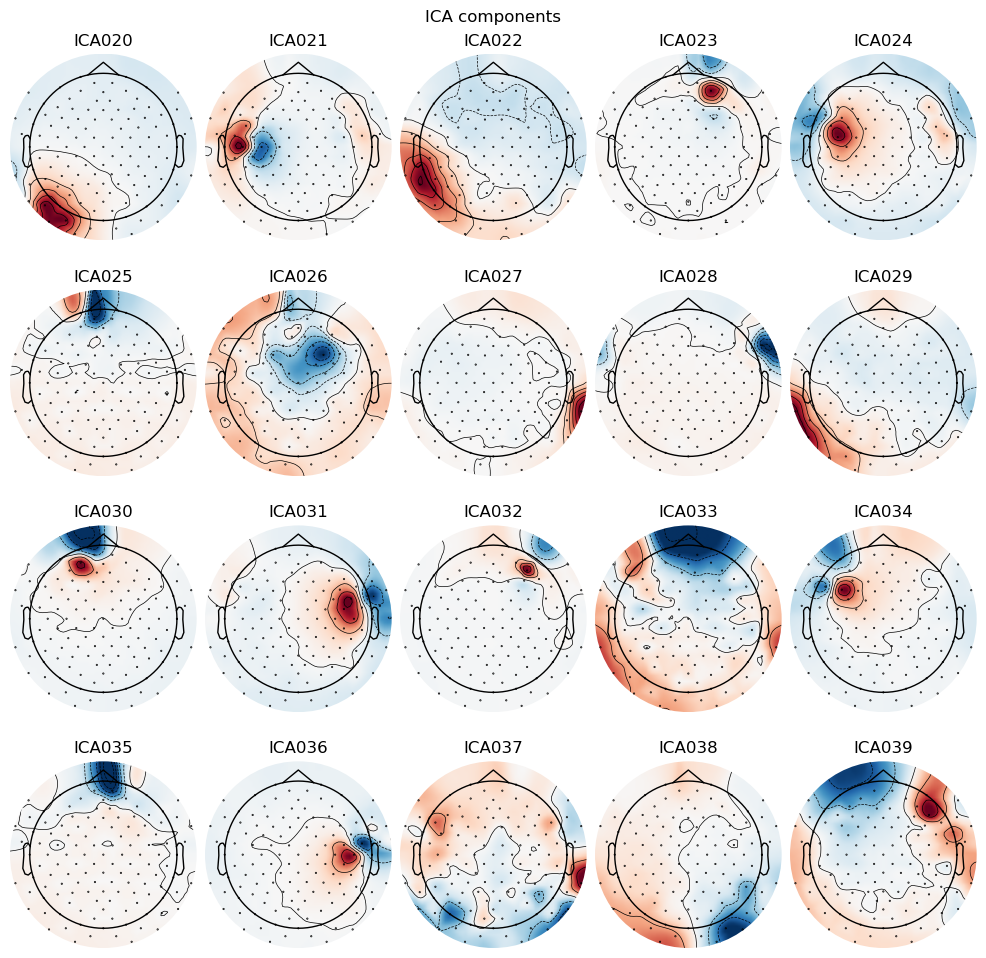

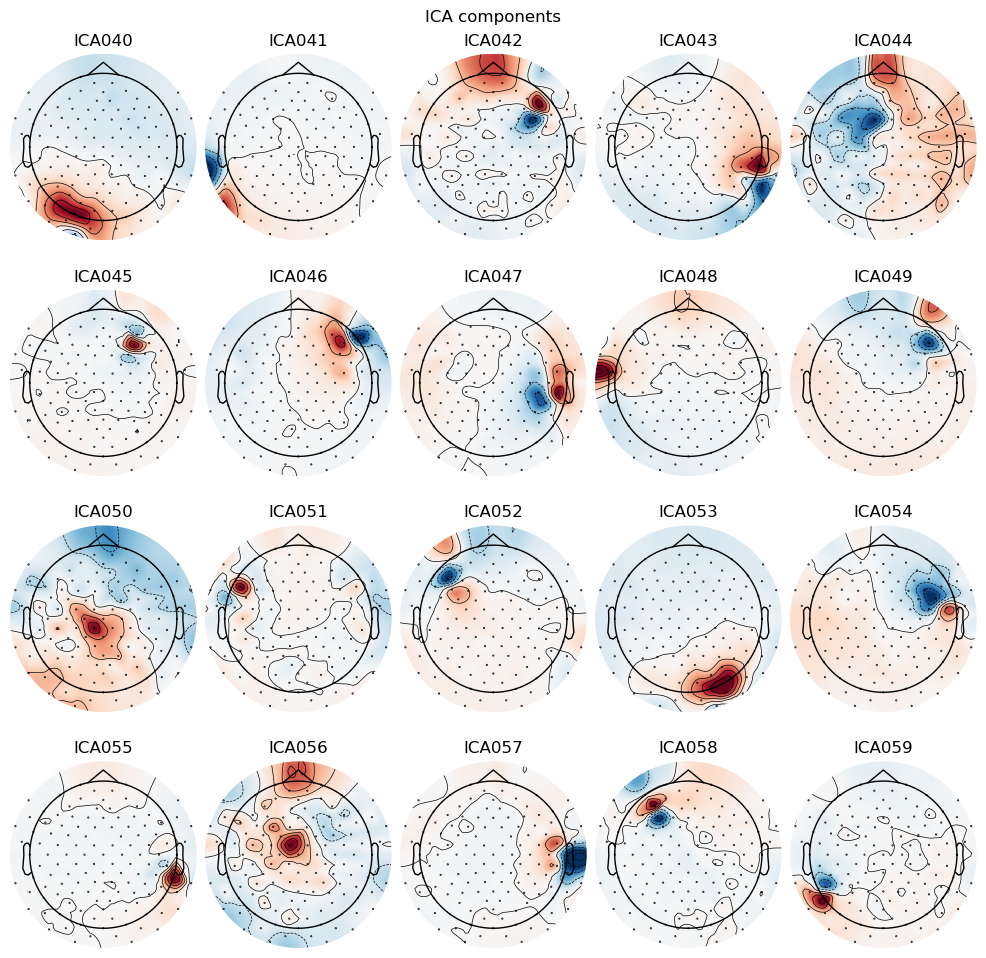

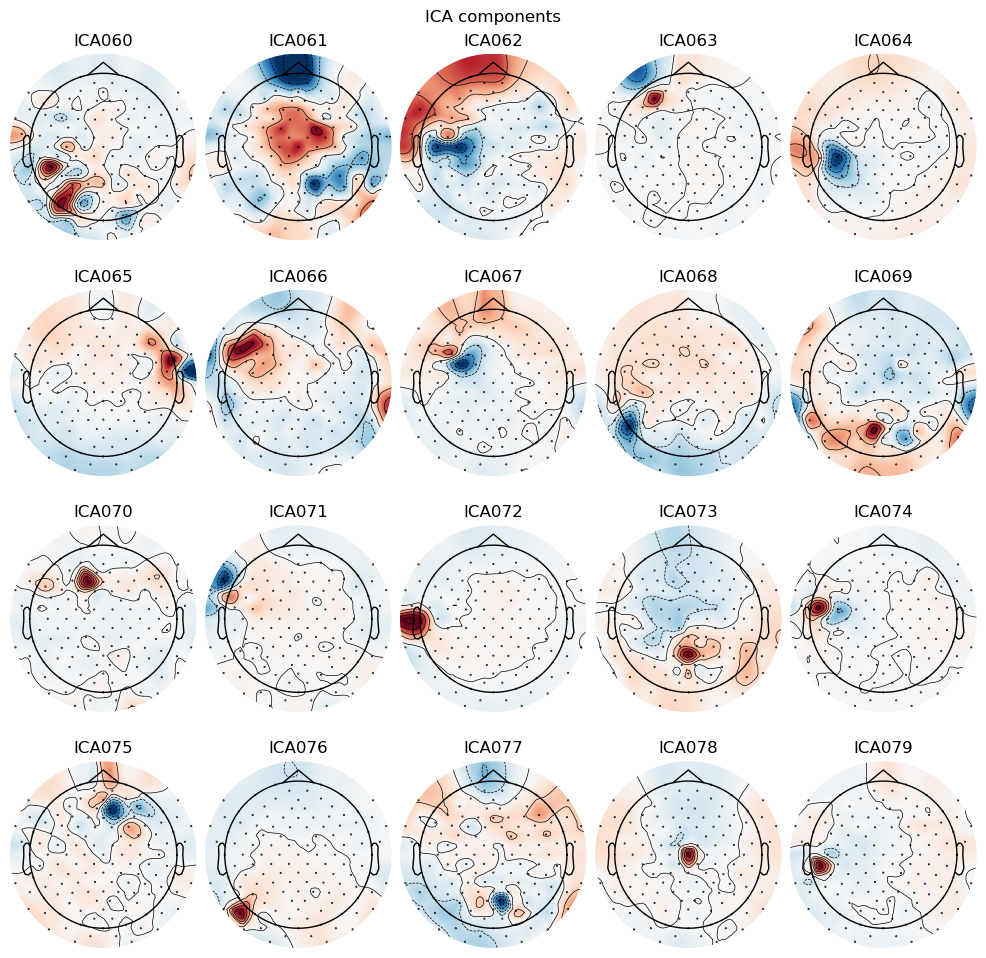

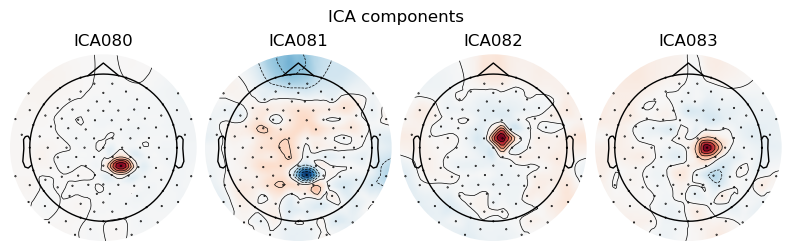

    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=84, n_times=661520
    Range : 0 ... 661519 =      0.000 ...   661.519 secs
Ready.
Using qt as 2D backend.


In [5]:
from mne.preprocessing import ICA

#bfore filtering, set common average reference for labeling
raw.set_eeg_reference('average', projection=True)

#apply projectionss for improved artifact removal
raw.apply_proj()

#apply filter for mne_icalabel which expects prefiltered data 1-100hz
raw.filter(1.,100., fir_design='firwin')

#create ICA object with picard from scikit-learn. default n_components=.99 which captures 99% of varience
#between infomax, which is a more classic approach, and fastfit from scikit-learn, picard is the quickest
#for ICLabel, you should select infomax or picard
ica = ICA(n_components=.99,method='picard',fit_params=dict(ortho=False, extended=True), random_state=97)

ica.fit(raw)

#plot the components
ica.plot_components(inst=raw)

ica.plot_sources(raw)



# 

this dataset did not contain marked ECG (eye) or EOG (heart) channels afaik. According to the manual for the Brain cap device used to collect the data, the amplifier has aux ports for ECG/EOG and will be labeled as such. In order to remove the artifacts, we will do our best to use automatic detection via ICLabel.

In [6]:
from mne_icalabel import label_components

#label components
labels = label_components(raw, ica, method='iclabel')

#components to be ignored
bad_labels = ['eye','heart','muscle']

#index for components to be ignored
bad_idx = [i for i, label in enumerate(labels['labels']) if label in bad_labels]

print(f"Removing ICA components: {bad_idx} - {', '.join(labels['labels'][i] for i in bad_idx)}")

#remove components
ica.exclude = bad_idx

#apply ICA to raw daya
raw_clean = ica.apply(raw)

#using the cleared and fitted data, we can now interpolate the bad channels from earlier (these were ignored automatically during ICA)
raw_clean.interpolate_bads()


C:\Users\benol\AppData\Local\Temp\ipykernel_34112\1173224349.py:4: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method='iclabel')


Removing ICA components: [] - 
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (84 components)
    Zeroing out 0 ICA components
    Projecting back using 127 PCA components
Setting channel interpolation method to {'eeg': 'spline'}.


C:\Users\benol\AppData\Local\Temp\ipykernel_34112\1173224349.py:21: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_clean.interpolate_bads()


<RawBrainVision | sub-01_task-rest_eeg.eeg, 127 x 661520 (661.5 s), ~641.1 MiB, data loaded>

# Filtering
Apply Finite Impulse Response (FIR) and Infinite Impulse Response (IIR) filters to clean the EEG signals by removing noise and unwanted frequency components
- I beleieve we would normally do this before ICA but because we used ```ICLabel``` which expected data filtered at 1-100 Hz, we will filter it post
- Preserve brainwave bands: Delta, Theta, Alpha, Beta, Gamma (up to ~60 Hz)
- Remove noise: Below 0.5 Hz and above 60 Hz

In [7]:

#high pass IIR filter to remove drift < 0.5 Hz. I guess its already filtered at 1 Hz but I wrote this before I switched methods so I'll leave it
iir_params = dict(order=5, ftype='butter', output='sos')
raw_clean.filter(l_freq=0.5, h_freq=None, method='iir', iir_params=iir_params)

#low pass FIR filter at 58 Hz
raw_clean.filter(l_freq=None, h_freq=60, method='fir', fir_design='firwin')

raw_clean.plot()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 10 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 221 samples (0.221 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.6s


# Downsampling
- Data is sampled at 1,000 Hz
- We do not need that level of resolution for this study
- The highest frequency we care about is the Gamma-band (60 Hz)
- Frequencies above 60 Hz were considered artifacts, as the EEG recordings we are interested in were collected while patients were resting with their eyes closed, where such high frequencies typically represent external noise rather than brain activity
- using ```raw.resample()``` we can resample the data with a target of 250 Hz, with a lowpass filter of 60 Hz
- Choose a rate at least 2x your highest frequency of interest, preferably 2.5–3x to stay safe
- best practices are:
    - low-pass filter the ```Raw``` data at or below 1/3 of the desired sample rate, then
    - decimate the data after epoching, by either passing the ```decim``` parameter to the ```Epochs``` constructor, or using the ```decimate()``` method after the ```Epochs``` have been created.
    - In MNE-Python, the resampling methods (```raw.resample()```, ```epochs.resample()``` and ```evoked.resample()```) apply a low-pass filter to the signal to avoid aliasing, so you don’t need to explicitly filter it yourself first.

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Effective window size : 4.096 (s)


c:\Users\benol\miniconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


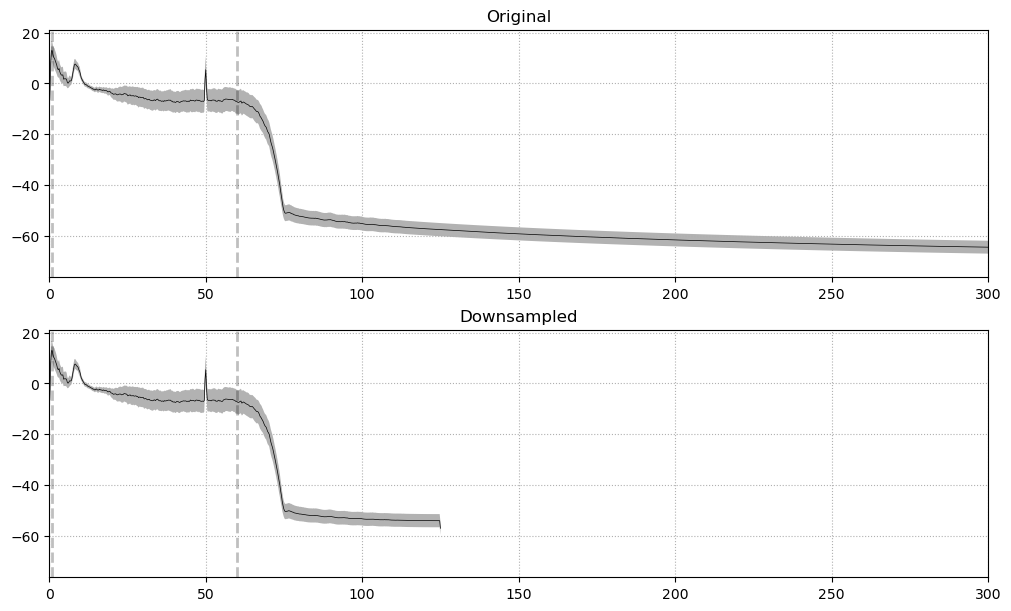

In [8]:
import matplotlib.pyplot as plt

raw_downsampled = raw_clean.copy().resample(sfreq=250)

# choose n_fft for Welch PSD to make frequency axes similar resolution
n_ffts = [4096, int(round(4096 * 250 / raw_clean.info["sfreq"]))]
fig, axes = plt.subplots(2, 1, sharey=True, layout="constrained", figsize=(10, 6))
for ax, data, title, n_fft in zip(
    axes, [raw_clean, raw_downsampled], ["Original", "Downsampled"], n_ffts
):
    fig = data.compute_psd(n_fft=n_fft).plot(
        average=True, amplitude=False, picks="data", exclude="bads", axes=ax
    )
    ax.set(title=title, xlim=(0, 300))